In [1]:
#import potrebnih biblioteka za K-means algoritam
%matplotlib inline
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

#Sklearn biblioteka sa implementiranim K-means algoritmom
from sklearn import datasets
from sklearn.cluster import KMeans
iris = datasets.load_iris() #Iris dataset koji će se koristiti kao primer https://en.wikipedia.org/wiki/Iris_flower_data_set

In [2]:
#import potrebnih biblioteka
import cv2
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [3]:
#Funkcionalnost implementirana u V1
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

#Funkcionalnost implementirana u V2
def resize_region(region):
    resized = cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
    return resized
def scale_to_range(image):
    return image / 255
def matrix_to_vector(image):
    return image.flatten()
def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        ready_for_ann.append(matrix_to_vector(scale_to_range(region)))
    return ready_for_ann
def convert_output(outputs):
    return np.eye(len(outputs))
def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]
def adaptivniMean(image_ada,prviParametar,drugiParametar):
    image_ada_bin = cv2.adaptiveThreshold(image_ada, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,prviParametar, drugiParametar)
    return image_ada_bin

def adaptivniGaus(image_ada,prviParametar,drugiParametar):
    image_ada_bin = cv2.adaptiveThreshold(image_ada, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,prviParametar, drugiParametar)
    return image_ada_bin
# adaptivni threshold gde se prag racuna = tezinska suma okolnih piksela, gde su tezine iz gausove raspodele


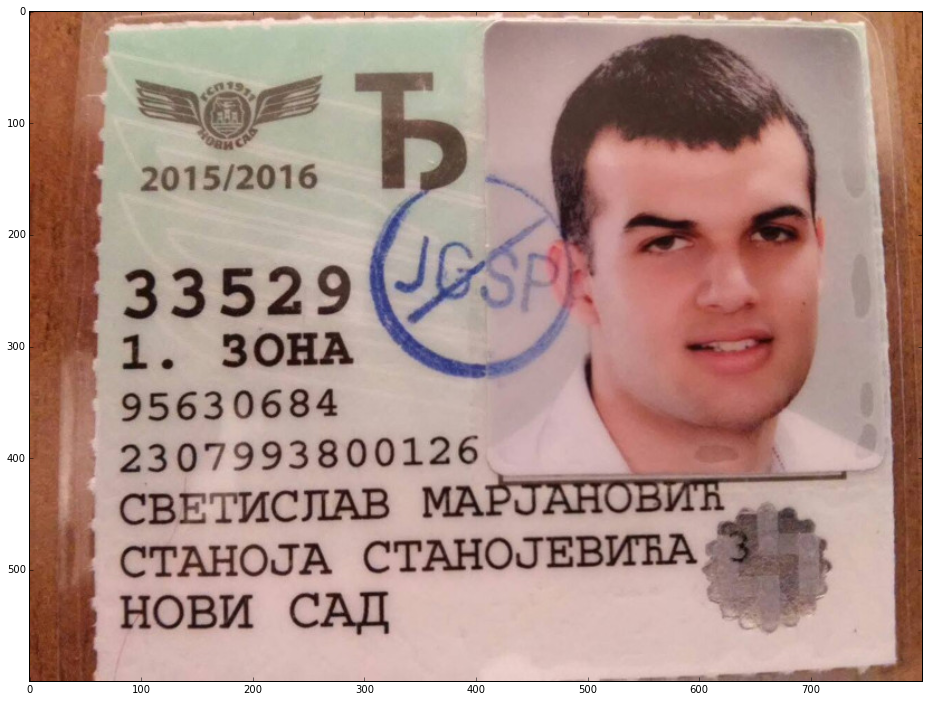

In [4]:
ucitanaSlika = load_image("slike/sveta12.jpg")
display_image(ucitanaSlika)

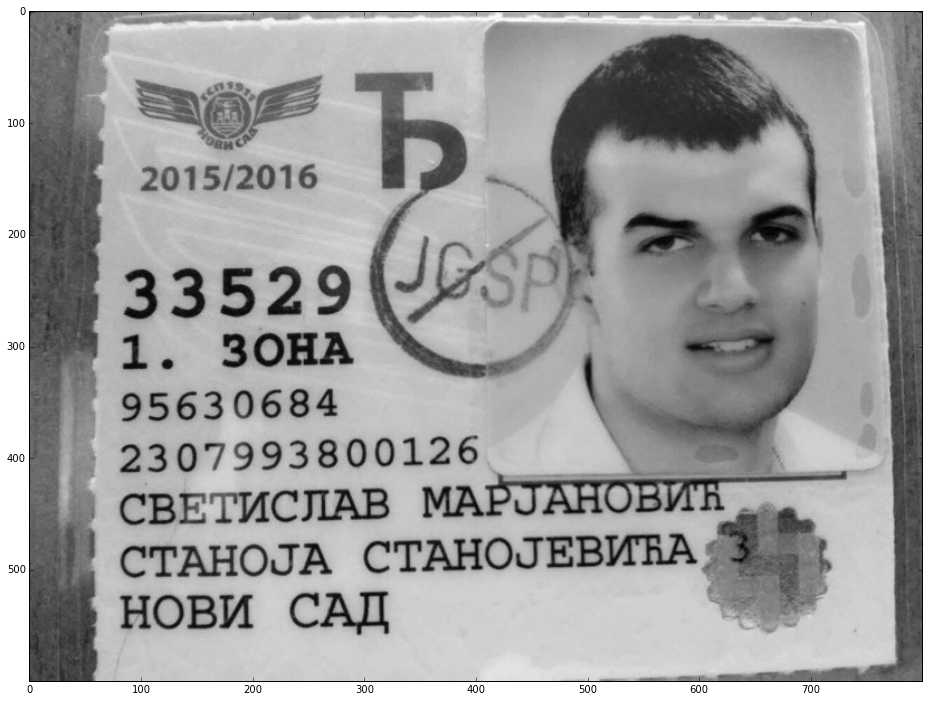

In [5]:
sivaSlika = image_gray(ucitanaSlika)
display_image(sivaSlika)

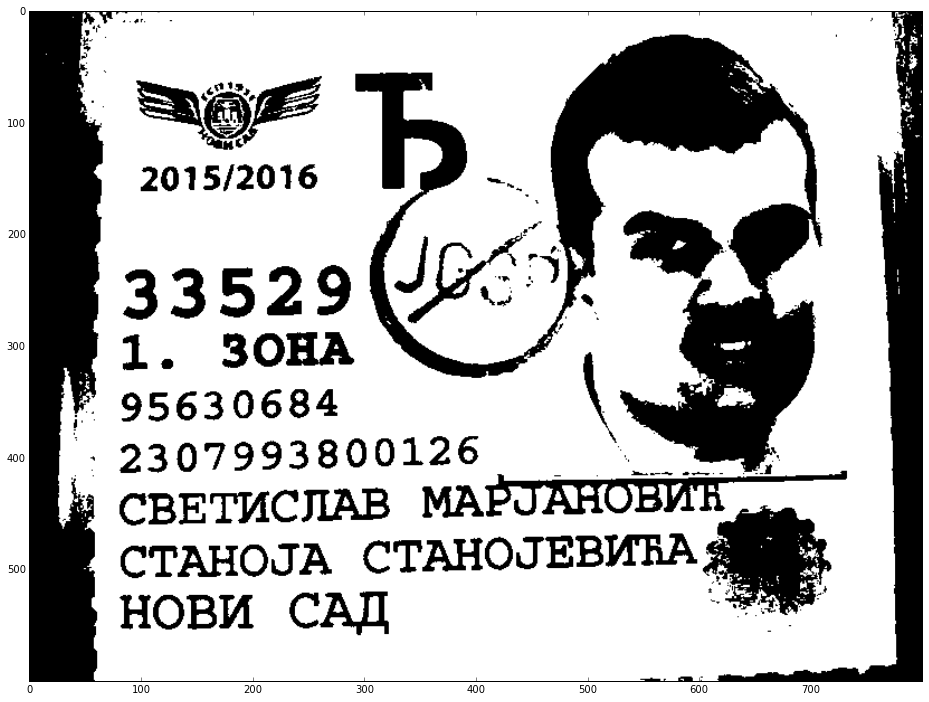

In [6]:
crnoBela = image_bin(sivaSlika)
display_image(crnoBela)

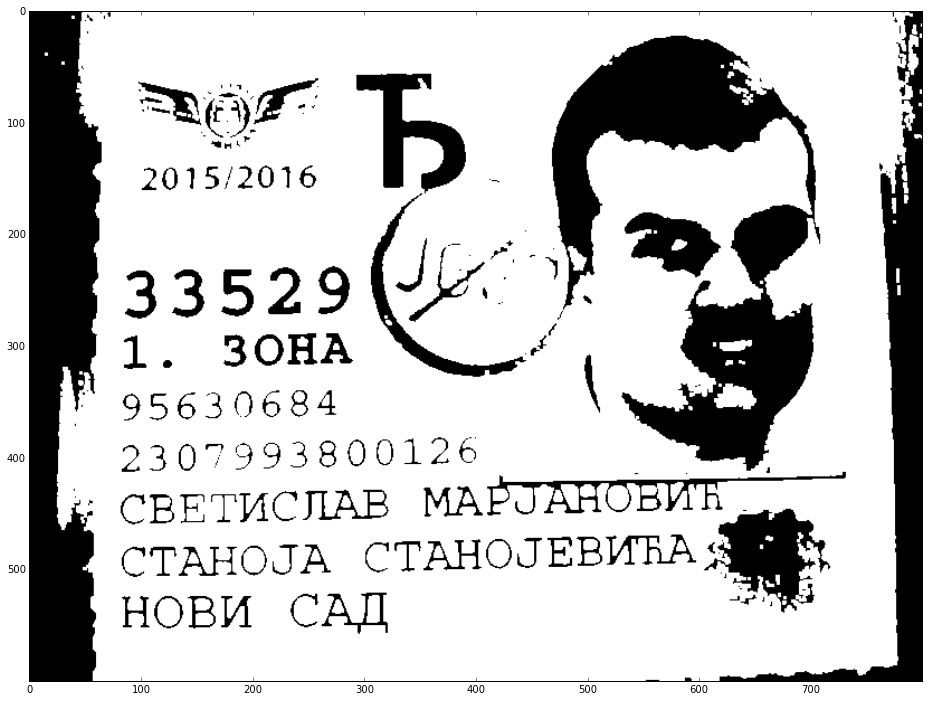

In [7]:
dilatacija = dilate(crnoBela)
display_image(dilatacija)

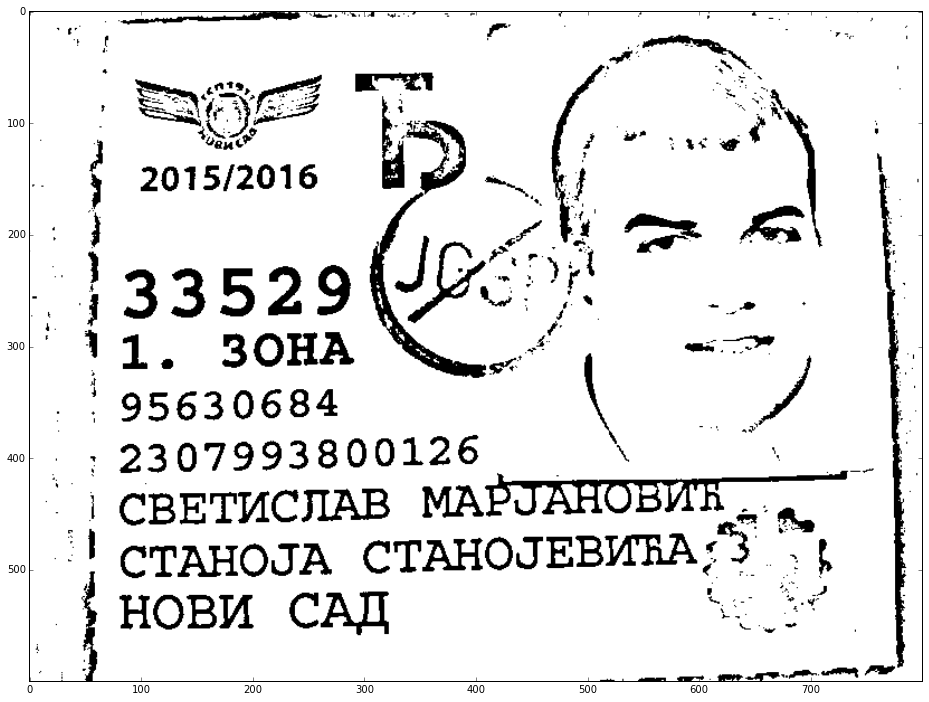

In [8]:
adaptivnaSlika = adaptivniGaus(sivaSlika,45,19)
display_image(adaptivnaSlika)

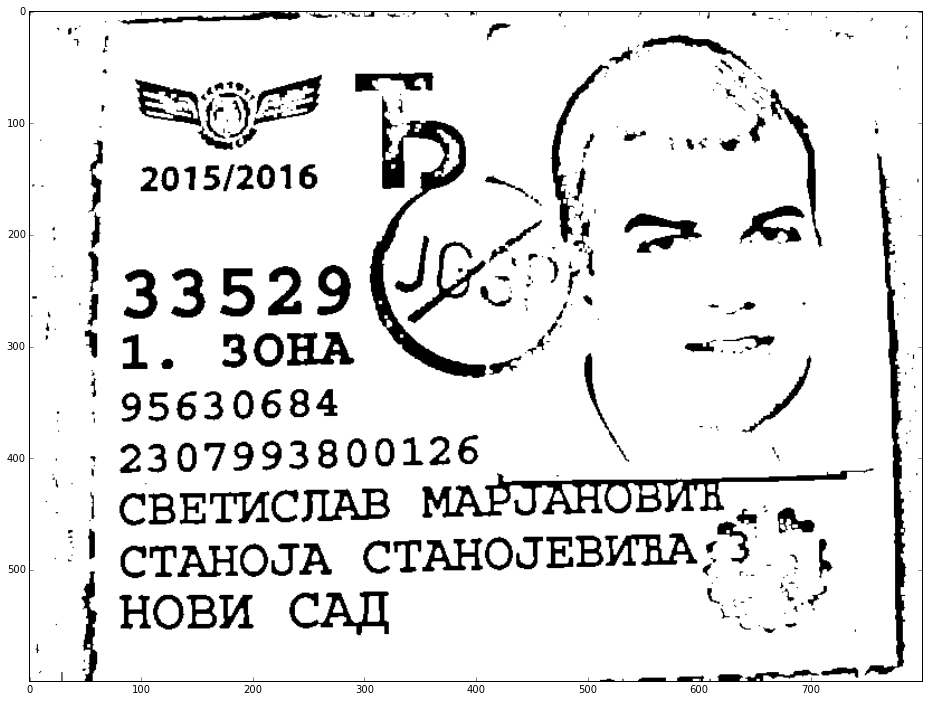

In [9]:
erozija = erode(adaptivnaSlika)
dilatacija2=dilate(erozija)
display_image(dilatacija2)

In [10]:
def select_roi(image_orig, image_bin):
    '''
    Funkcija kao u vežbi 2, iscrtava pravougaonike na originalnoj slici, pronalazi sortiran niz regiona sa slike,
    i dodatno treba da sačuva rastojanja između susednih regiona.
    '''
    height,width=image_orig.shape[0:2]
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Način određivanja kontura je promenjen na spoljašnje konture: cv2.RETR_EXTERNAL
    regions_dict = {}
    print len(contours)
    for contour in contours: 
        
        x,y,w,h = cv2.boundingRect(contour)
        
        if w>8 and h<100 and w*h<1500 and h>w and h<w*2.8 and x<width/2 and x>80 and y>110:
           
            region = image_bin[y:y+h+1,x:x+w+1];
            # Proširiti regions_dict elemente sa vrednostima boundingRect-a ili samim konturama
            regions_dict[x] = [resize_region(region), (x,y,w,h)]
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)

    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

In [11]:
def select_roi1(image_orig, image_bin):
    '''
    Funkcija kao u vežbi 2, iscrtava pravougaonike na originalnoj slici, pronalazi sortiran niz regiona sa slike,
    i dodatno treba da sačuva rastojanja između susednih regiona.
    '''
    height,width=image_orig.shape[0:2]
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Način određivanja kontura je promenjen na spoljašnje konture: cv2.RETR_EXTERNAL
    regions_dict = {}
    print len(contours)
    for contour in contours: 
        
        x,y,w,h = cv2.boundingRect(contour)
        if w>8 and h<100 and h>15:
            region = image_bin[y:y+h+1,x:x+w+1];
            # Proširiti regions_dict elemente sa vrednostima boundingRect-a ili samim konturama
            regions_dict[x] = [resize_region(region), (x,y,w,h)]
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)

    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    
    return image_orig, sorted_regions[:, 0], region_distances

410


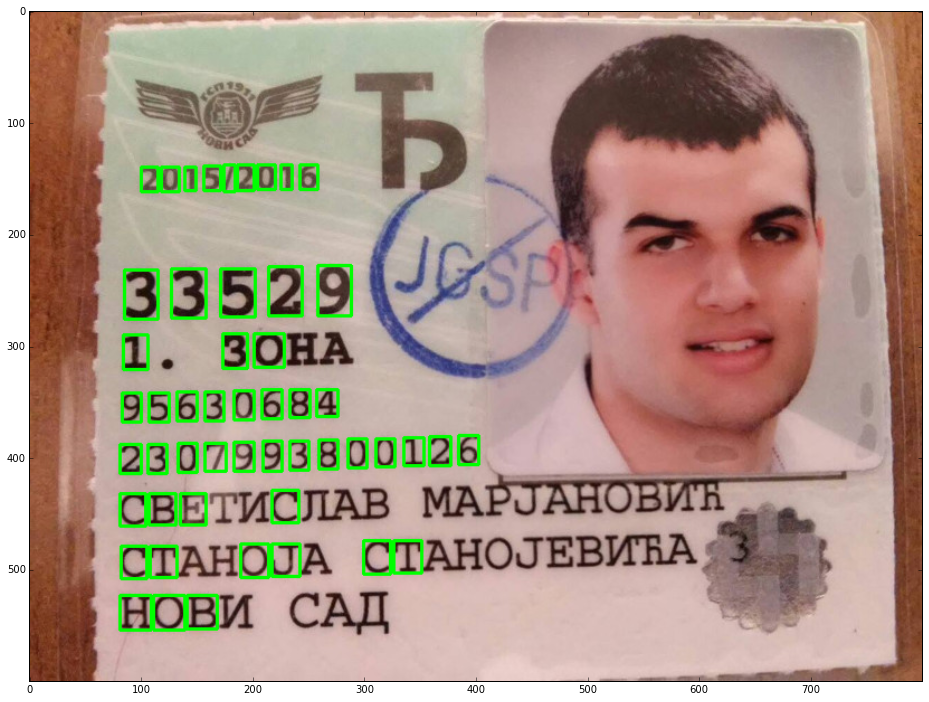

In [12]:
regioniSlika,regioni,distance=select_roi(ucitanaSlika.copy(),invert(dilatacija2))
display_image(regioniSlika)


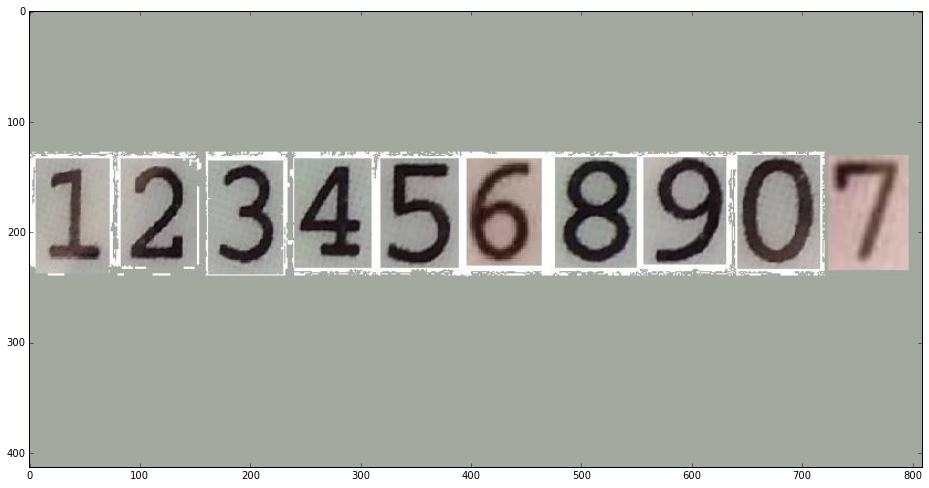

In [13]:
ucitanaSlika1 = load_image("slike/ob.jpg")
display_image(ucitanaSlika1)

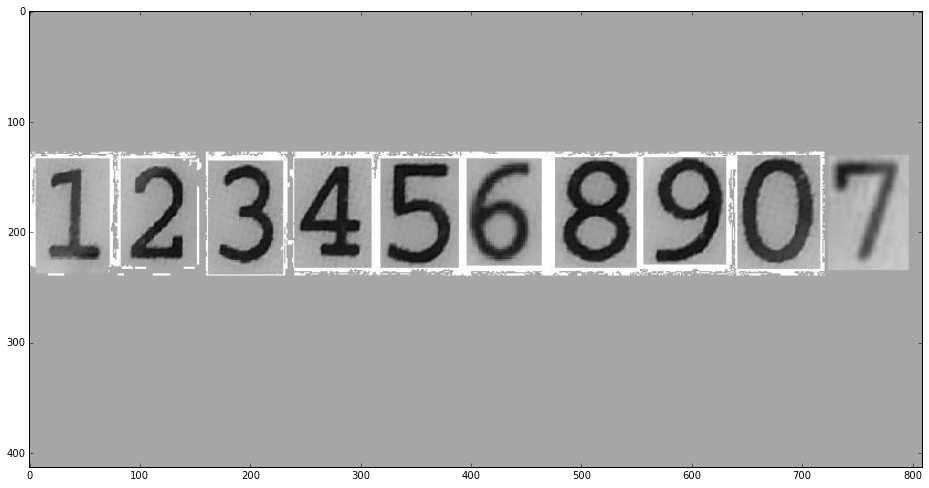

In [14]:
sivaSlika1 = image_gray(ucitanaSlika1)
display_image(sivaSlika1)

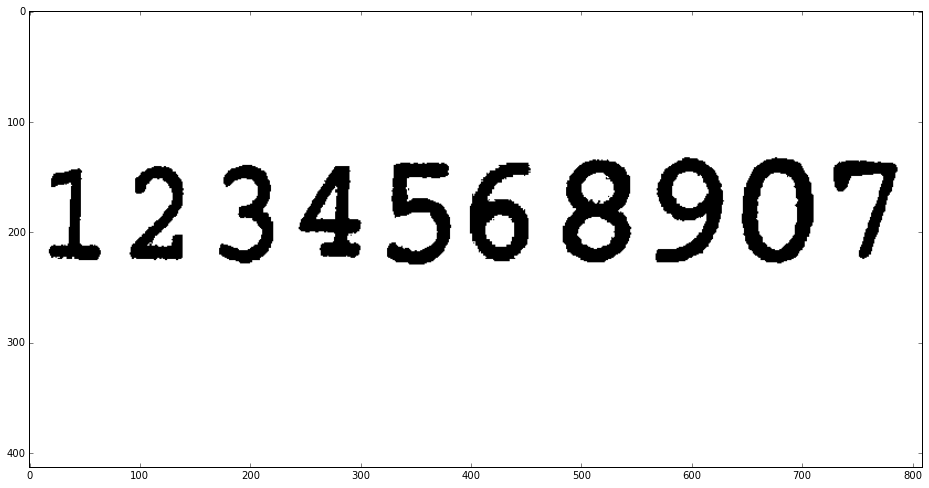

In [15]:
crnoBela1 = image_bin(sivaSlika1)
display_image(crnoBela1)

In [ ]:
adaptivnaSlika1 = adaptivniGaus(sivaSlika1,45,19)
display_image(adaptivnaSlika1)

In [ ]:
erozija1 = erode(adaptivnaSlika1)
dilatacija21=dilate(erozija1)
display_image(dilatacija21)

13


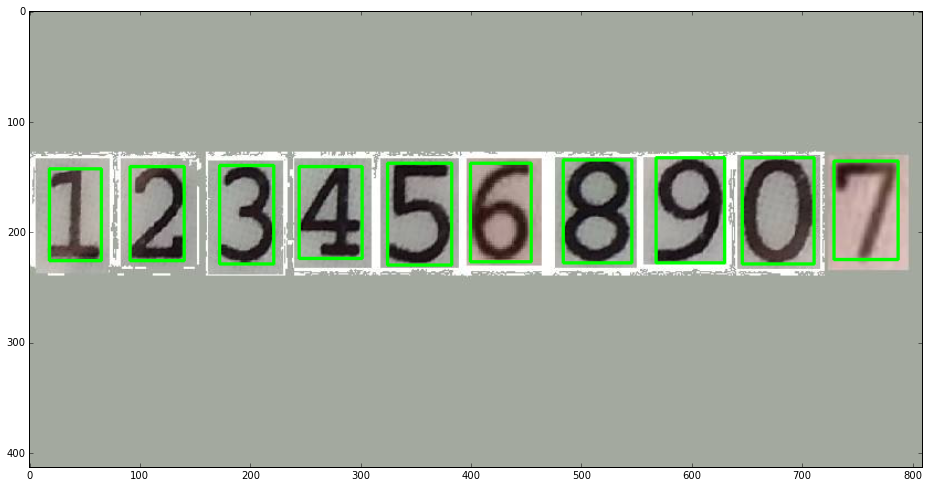

In [16]:
regioniSlika1,regioni1,distance1=select_roi1(ucitanaSlika1.copy(),invert(crnoBela1))

display_image(regioniSlika1)

In [18]:
def create_ann():
    '''
    Implementirati veštačku neuronsku mrežu sa 28x28 ulaznih neurona i jednim skrivenim slojem od 128 neurona.
    Odrediti broj izlaznih neurona. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    # Postaviti slojeve neurona mreže 'ann'
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    X_train = np.array(X_train, np.float32)
    y_train = np.array(y_train, np.float32)
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=500, batch_size=1, verbose = 0, shuffle=False, show_accuracy = False) 
      
    return ann

In [19]:
#njihova metoda za prikaze rezultata rada neuronske mreze
def display_result(outputs, alphabet, k_means):
    '''
    Funkcija određuje koja od grupa predstavlja razmak između reči, a koja između slova, i na osnovu
    toga formira string od elemenata pronađenih sa slike.
    Args:
        outputs: niz izlaza iz neuronske mreže.
        alphabet: niz karaktera koje je potrebno prepoznati
        kmeans: obučen kmeans objekat
    Return:
        Vraća formatiran string
    '''
    # Odrediti indeks grupe koja odgovara rastojanju između reči, pomoću vrednosti iz k_means.cluster_centers_
    #w_space_group = max(enumerate(k_means.cluster_centers_), key = lambda x: x[1])[0]
    result = alphabet[winner(outputs[0])]
    for idx, output in enumerate(outputs[1:,:]):
        # Iterativno dodavati prepoznate elemente kao u vežbi 2, alphabet[winner(output)]
        # Dodati space karakter u slučaju da odgovarajuće rastojanje između dva slova odgovara razmaku između reči.
        # U ovu svrhu, koristiti atribut niz k_means.labels_ koji sadrži sortirana rastojanja između susednih slova.
        #if (k_means.labels_[idx] == w_space_group):
            #result += ' '
        result += alphabet[winner(output)]
    return result

In [20]:
alphabet = ['1', '2', '3', '4', '5', '6', '8', '9', '0', '7'] 

In [21]:
#priprema izdvojenih regiona sa slike za ucenje a potom i sa ciljane slike
inputs = prepare_for_ann(regioni1)
inputs2 = prepare_for_ann(regioni)
outputs = convert_output(alphabet)
#kreiranje neuronske mreze


In [22]:
ann = create_ann()
ann = train_ann(ann, inputs, outputs)

In [23]:

results = ann.predict(np.array(inputs2, np.float32))
k_means=[]
rez= display_result(results, alphabet, k_means)
print rez

20913235100360578535310200069207864980001126


In [43]:
#Naredna funkcija(select roi) vraca 2 povratnu vrednost koja je dictionary ( regions_dictY) koji sadrzi liste regiona po redovima
#primer regions_dictY[3] daje listu regiona u 4. redu. onda recimo prvu konturu u 4. redu bi dobio kao regions_dictY[3][0]
def select_roi(image_orig, image_bin,lineNumber):
    '''
    Funkcija kao u vežbi 2, iscrtava pravougaonike na originalnoj slici, pronalazi sortiran niz regiona sa slike,
    i dodatno treba da sačuva rastojanja između susednih regiona.
    '''
    height,width=image_orig.shape[0:2]
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #Način određivanja kontura je promenjen na spoljašnje konture: cv2.RETR_EXTERNAL
    regions_dict = {}
    regions_dictY = {}
    listaY=list()
    print len(contours)
    yOld=0
    i=0
    for contour in contours: 
        
        x,y,w,h = cv2.boundingRect(contour)
        if w>8 and h<100 and w*h<1500 and h>w and h<w*2.8 and x<width/2 and x>80 and y>110:
            region = image_bin[y:y+h+1,x:x+w+1];
            # Proširiti regions_dict elemente sa vrednostima boundingRect-a ili samim konturama
            regions_dict[x] = [resize_region(region), (x,y,w,h)]
            
            
            if abs(y-yOld)<30:
                
                listaY.append([resize_region(region), (x,y,w,h)])
                #print x,y,yOld
            else:
                #print "duzina liste" + str(len(listaY))
                
                regions_dictY[i] = copy.deepcopy(listaY)
                listaY=list()
                listaY.append([resize_region(region), (x,y,w,h)])
                
                i=i+1
                yOld=y
            if i==4:
                cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
            elif i==6:
                cv2.rectangle(image_orig,(x,y),(x+w,y+h),(255,0,0),2)
            elif i==7:
                cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,0,255),2)
            else:
                cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,100,100),2)

    sorted_regions_dict = collections.OrderedDict(sorted(regions_dict.items()))
    sorted_regions = np.array(sorted_regions_dict.values())
    sorted_regionsY=np.array(regions_dictY[lineNumber])
    #print "Broj regiona" + str(len(regions_dictY))
    sorted_rectangles = sorted_regions[:,1]
    region_distances = [-sorted_rectangles[0][0]-sorted_rectangles[0][2]]
    # Izdvojiti sortirane parametre opisujućih pravougaonika
    # Izračunati rastojanja između svih susednih regiona po x osi i dodati ih u region_distances niz
    for x,y,w,h in sorted_regions[1:-1, 1]:
        region_distances[-1] += x
        region_distances.append(-x-w)
    region_distances[-1] += sorted_rectangles[-1][0]
    #print "y duzina" + str(len(regions_dictY))
    
    return image_orig, regions_dictY, region_distances

In [39]:
#pomocna funkcija koja vraca x komponentu regiona
def getXComponentOfRegion(region):
    return region[1][0]

In [40]:
#list of regions = lista regiona u dictionary-u
# sortira najjednostavnije sve regione u toj listi ( red na slici) po x komponenti u rastucem poretku
def sortRegionListByXComponent(listOfRegions):
    for i in range(0,len(listOfRegions)-1):
        for j in range(i+1,len(listOfRegions)):
            if (getXComponentOfRegion(listOfRegions[j]) < getXComponentOfRegion(listOfRegions[i]) ):
                    temp=listOfRegions[i]
                    listOfRegions[i]=listOfRegions[j]
                    listOfRegions[j]=temp

In [45]:
#sortiraj liste regiona po x
regioniSlika,regioni,distance=select_roi(ucitanaSlika.copy(),invert(dilatacija2),4)
for i in range(0,len(regioni)):
    sortRegionListByXComponent(regioni[i])

410


broj kontura u  redu : 1 je 3
(81, 523, 28, 31)
(111, 523, 28, 31)
(141, 523, 27, 30)
broj kontura u  redu : 2 je 6
(82, 479, 23, 29)
(108, 479, 24, 28)
(189, 477, 25, 30)
(217, 477, 25, 29)
(299, 474, 24, 30)
(326, 474, 25, 29)
broj kontura u  redu : 3 je 4
(81, 432, 23, 29)
(107, 432, 24, 28)
(135, 432, 23, 28)
(217, 429, 24, 29)
broj kontura u  redu : 4 je 13
(81, 388, 19, 26)
(106, 388, 17, 26)
(133, 387, 17, 26)
(157, 387, 19, 25)
(183, 386, 18, 26)
(209, 385, 17, 27)
(233, 385, 17, 26)
(259, 384, 17, 26)
(285, 383, 17, 26)
(310, 383, 17, 25)
(335, 382, 18, 25)
(358, 381, 19, 26)
(384, 380, 18, 26)
broj kontura u  redu : 5 je 8
(83, 342, 17, 26)
(107, 342, 18, 26)
(132, 341, 18, 26)
(157, 341, 17, 26)
(183, 340, 18, 26)
(208, 339, 18, 26)
(233, 339, 18, 25)
(257, 339, 19, 24)
broj kontura u  redu : 6 je 3
(84, 290, 22, 31)
(173, 289, 22, 31)
(201, 289, 27, 30)
broj kontura u  redu : 7 je 5
(85, 232, 30, 44)
(127, 231, 31, 44)
(171, 231, 31, 43)
(214, 229, 30, 44)
(258, 228, 30, 45

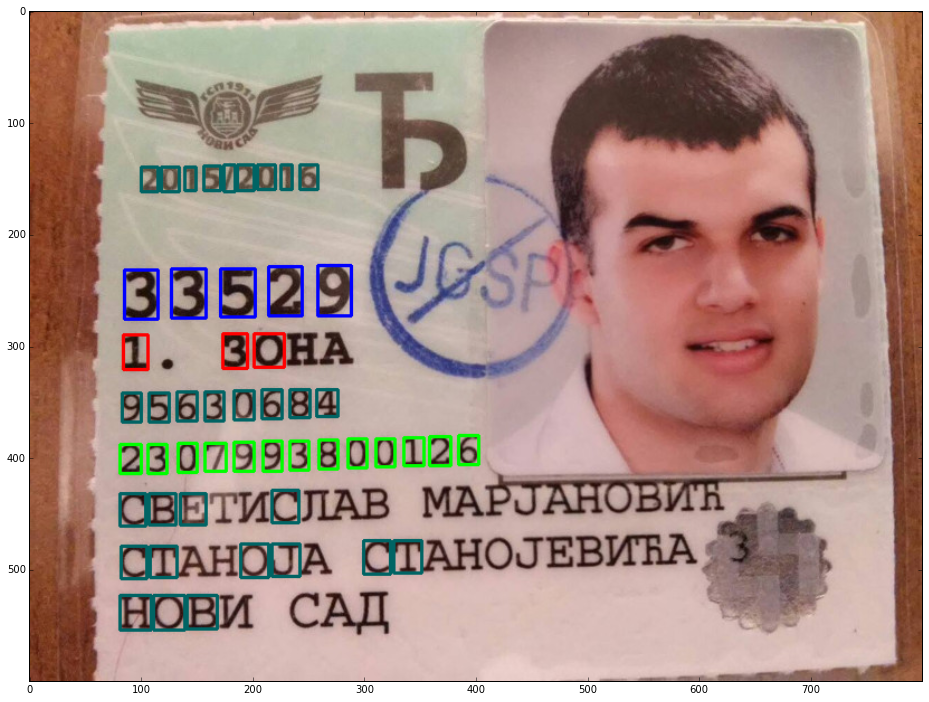

In [46]:
#prolazak kroz dictionary  odnosno kroz sve redove i   ispisuje x,y,w,h  za svaki konturu u  redu

for i in range (1,len(regioni)):
    print "broj kontura u  redu : " + str(i) + " je "+str(len(regioni[i]))
    for j in range(0,len(regioni[i])):
        print regioni[i][j][1]

plt.figure()
display_image(regioniSlika)